# 07-3 신경망 모델 훈련

손실 곡선

In [44]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [45]:
def model_fn(a_layer=None):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))
  model.add(keras.layers.Dense(100, activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10, activation='softmax'))
  return model

In [46]:
model = model_fn()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 784)               0         
                                                                 
 dense_20 (Dense)            (None, 100)               78500     
                                                                 
 dense_21 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [48]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


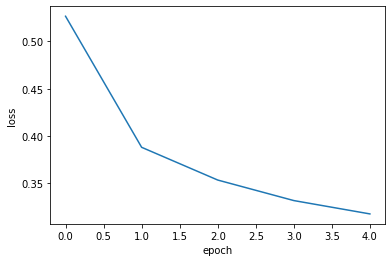

In [49]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

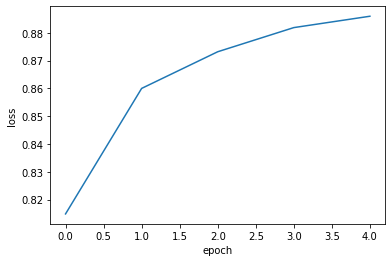

In [50]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

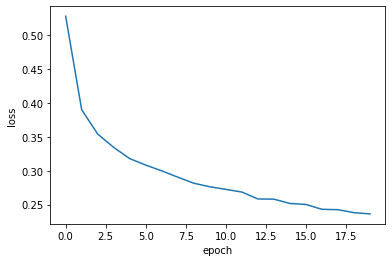

In [51]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

검증 손실

In [ ]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


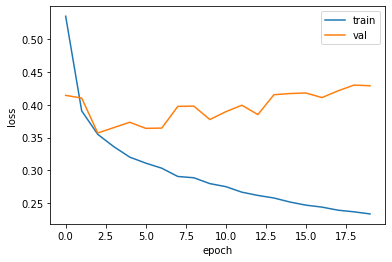

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

Adam Optimizer 이용

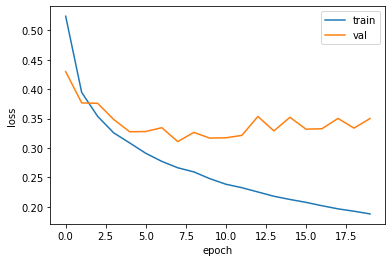

In [ ]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

드롭아웃(dropout) : 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(즉, 뉴런의 출력을 0으로 만들어) 과대적합을 막음. 평가 시에는 모든 뉴런을 사용함.

몇 퍼센트를 끌지는 지정, 어떤 뉴런을 끌지는 랜덤

In [ ]:
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               78500     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

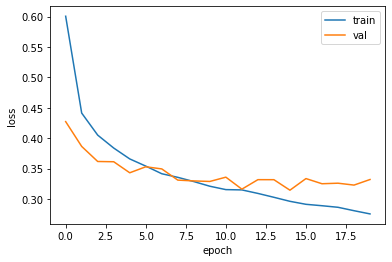

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

모델 저장과 복원

In [52]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

In [53]:
model.save_weights('model-weights.h5') # 모델의 구조는 저장하지 않고 모델 파라미터(가중치, 절편)만 저장

In [54]:
model.load_weights('model-weights.h5')

In [55]:
model.save('model-whole.h5') # 모델의 구조와 모델 파라미터를 함께 저장

In [56]:
model = keras.models.load_model('model-whole.h5')

In [57]:
!ls -al *.h5

-rw-r--r-- 1 root root 333448 Feb  6 14:25 model-weights.h5
-rw-r--r-- 1 root root 982664 Feb  6 14:25 model-whole.h5


In [58]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [59]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis=-1) # axis=-1 각 행의 최댓값의 인덱스
print(np.mean(val_labels == val_target))

0.8818333333333334


In [60]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3344 - accuracy: 0.8818


[0.33440160751342773, 0.8818333148956299]

-> 같은 모델을 저장하고 다시 불러들였기 때문에 동일한 정확도를 얻을 수 있음

콜백(callback) : 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들

In [61]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [62]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

In [64]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.3114 - accuracy: 0.8867


[0.3114151060581207, 0.8867499828338623]

조기 종료(early stopping)

In [65]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [66]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

In [67]:
print(early_stopping_cb.stopped_epoch)

9


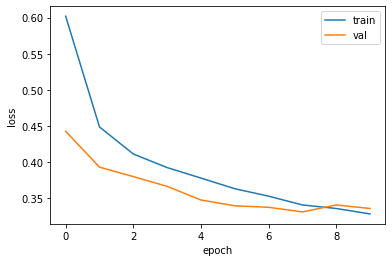

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [69]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.3305 - accuracy: 0.8783


[0.33049923181533813, 0.878250002861023]